# Tutorial: Decision Trees and Random Forests
Applied to the California housing dataset

### Importing Modules

In [65]:
# importing required libraries
import numpy as np
import pandas as pd

# importing Scikit-learn library and datasets package
from sklearn.datasets import fetch_california_housing

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Import MLR
from sklearn.linear_model import LinearRegression

# importing decision tree from tree module
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

# importing random forest classifier from ensemble module
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

# using metrics module for MSE, MAE, and R2 score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate

### Importing the California housing dataset

In [66]:
# housing = fetch_california_housing(as_frame=True)

The sklearn dataset fetch_california_housing does not explicitly have the information whether the houses are located close to the ocean, or are inland. It can be calculated using the latitude and longitude provided and using Google maps. Instead we use a csv file with that information as a categorical column 'ocean_proximity'. The categories are ['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND'], where '<1H OCEAN' means the place is less than 1 hour drive from the ocean.

In [67]:
housing = pd.read_csv('housing.csv')
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


### Data Preparation


In [68]:
housing[pd.isnull(housing).any(axis=1)].head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY
738,-122.14,37.67,37.0,3342.0,NaN,1635.0,557.0,4.7933,186900.0,NEAR BAY
1097,-121.77,39.66,20.0,3759.0,NaN,1705.0,600.0,4.7120,158600.0,INLAND
1350,-121.95,38.03,5.0,5526.0,NaN,3207.0,1012.0,4.0767,143100.0,INLAND
1456,-121.98,37.96,22.0,2987.0,NaN,1420.0,540.0,3.6500,204100.0,INLAND
1493,-122.01,37.94,23.0,3741.0,NaN,1339.0,499.0,6.7061,322300.0,NEAR BAY


In [69]:
housing.isnull().any()
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

We see that the total_bedrooms attribute has some NANs. Most ML algorithms cannot work with datasets that have missing values.

There are 3 ways to solve this problem:

1. You could remove the whole attribute

2. You could get rid of the districts that contain missing values.

3. You could replace them with zeros, the median or the mean

We chose option 3 and will compute the median on the training set.

Sklearn provides `Imputer' to do this. We first need to specify an Imputer instance, that specifies that we want to replace each attributes missing values with the median of that attribute. Because the median can only be computed on numerical attributes, we need to make a copy of the data without the ocean_proximity attribute that contains text and no numbers.

In [70]:
housing['total_bedrooms'] = housing['total_bedrooms'].fillna(housing['total_bedrooms'].median())

In [71]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Check if all NANs have been replace

In [72]:
housing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

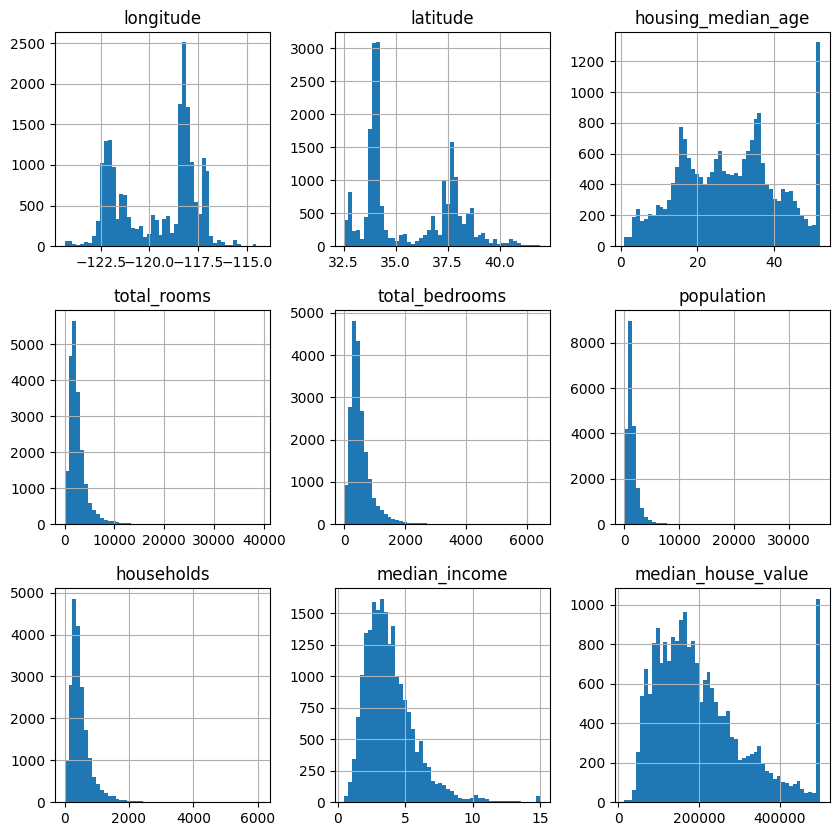

In [73]:
housing.hist(bins=50, figsize=(10, 10))
plt.show()

<Axes: >

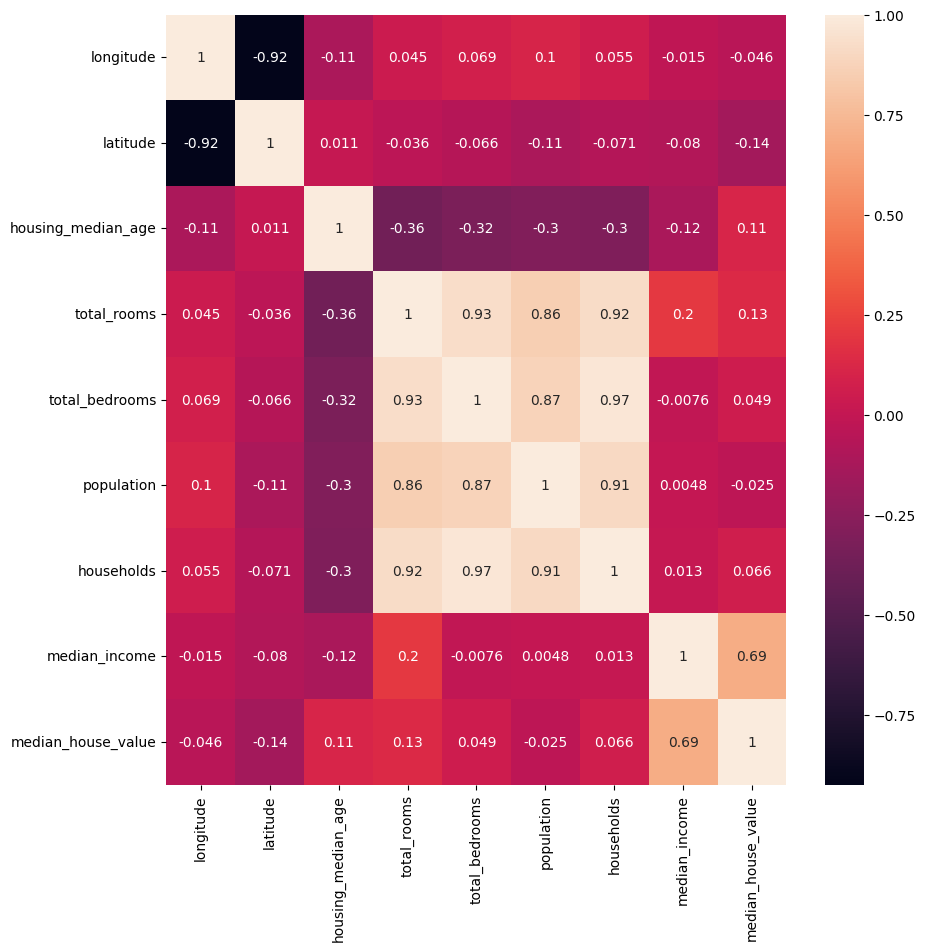

In [74]:
plt.figure(figsize=(10, 10))
sns.heatmap(housing.iloc[:,:-1].corr(), annot=True)

Do you know what the map of California looks like?

The 'ocean_proximity' feature seems quite important.

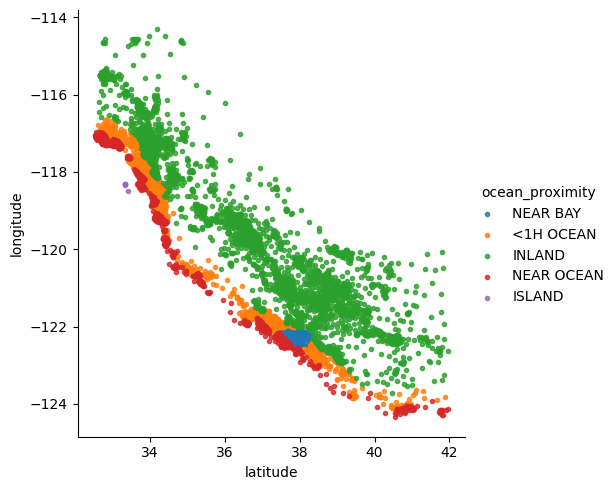

In [75]:
sns.lmplot(y='longitude', x='latitude', data=housing, markers ='.', hue='ocean_proximity', fit_reg=False, height=5)

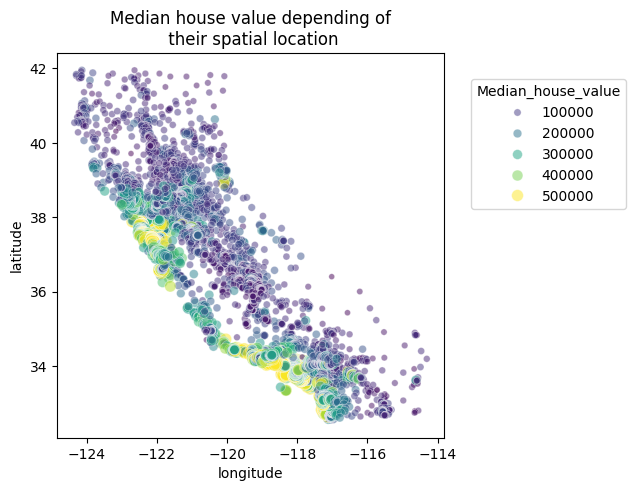

In [76]:
plt.figure(figsize=(5, 5))
sns.scatterplot(
    data=housing,
    x="longitude",
    y="latitude",
    size="median_house_value",
    hue="median_house_value",
    palette="viridis",
    alpha=0.5,
)
plt.legend(title="Median_house_value", bbox_to_anchor=(1.05, 0.95), loc="upper left")
_ = plt.title("Median house value depending of\n their spatial location")

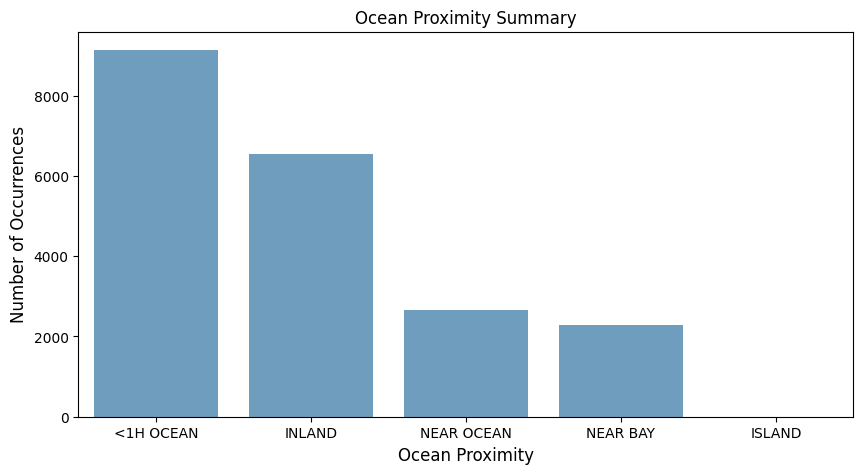

In [77]:
op_count = housing['ocean_proximity'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x=op_count.index, y=op_count.values, alpha=0.7)
plt.title('Ocean Proximity Summary')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Ocean Proximity', fontsize=12)
plt.show()

### Scaling the numerical features

Initialize a StandardScaler and scale the features, transforming them by scaling them to a given range. The fit_transform() method fits to the data and then transforms it. We don't need to scale the target y. The X, y generated here will be used as the original dataset for splitting the dataset into training and testing datasets.

In [78]:
num_features=list(housing.columns)
num_features.remove('ocean_proximity')
num_features.remove('median_house_value')
print(num_features)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


In [79]:
scaler = MinMaxScaler()

num_features_scaled=pd.DataFrame(scaler.fit_transform(housing[num_features]),columns=num_features)
num_features_scaled

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,0.211155,0.567481,0.784314,0.022331,0.019863,0.008941,0.020556,0.539668
1,0.212151,0.565356,0.392157,0.180503,0.171477,0.067210,0.186976,0.538027
2,0.210159,0.564293,1.000000,0.037260,0.029330,0.013818,0.028943,0.466028
3,0.209163,0.564293,1.000000,0.032352,0.036313,0.015555,0.035849,0.354699
4,0.209163,0.564293,1.000000,0.041330,0.043296,0.015752,0.042427,0.230776
...,...,...,...,...,...,...,...,...
20635,0.324701,0.737513,0.470588,0.042296,0.057883,0.023599,0.054103,0.073130
20636,0.312749,0.738576,0.333333,0.017676,0.023122,0.009894,0.018582,0.141853
20637,0.311753,0.732200,0.313725,0.057277,0.075109,0.028140,0.071041,0.082764
20638,0.301793,0.732200,0.333333,0.047256,0.063315,0.020684,0.057227,0.094295


### Categorical Encoding

In [80]:
#Checking the columns with categorical values.
object_columns = housing.columns[housing.dtypes == 'object']
object_columns

Index(['ocean_proximity'], dtype='object')

In [81]:
print(housing['ocean_proximity'].unique())
housing['ocean_proximity'].value_counts()

['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']


ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [82]:
# Inspecting the Categorical attribute
housing_cat = housing[["ocean_proximity"]]
housing_cat

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY
...,...
20635,INLAND
20636,INLAND
20637,INLAND
20638,INLAND


### Encoding the categorical column with One-Hot Encoding

In [83]:
# Handling Categorical Attributes
from sklearn.preprocessing import OneHotEncoder

# Instantiating the OneHot Encoder class
ohe = OneHotEncoder(sparse_output=False)

# Encoding the Text
housing_cat_onehot = ohe.fit_transform(housing_cat)

# Converting into numpy arrays.
print(housing_cat_onehot[:10])
print("\n")
print(ohe.categories_)

categorical_columns = housing.select_dtypes(include=['object']).columns.tolist()
#Create a DataFrame with the one-hot encoded columns
#We use get_feature_names_out() to get the column names for the encoded data
housing_ohe = pd.DataFrame(housing_cat_onehot, columns=ohe.get_feature_names_out(categorical_columns))

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


### Features and Targets

In [84]:
X = pd.concat([num_features_scaled,housing_ohe],axis=1)
X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.211155,0.567481,0.784314,0.022331,0.019863,0.008941,0.020556,0.539668,0.0,0.0,0.0,1.0,0.0
1,0.212151,0.565356,0.392157,0.180503,0.171477,0.067210,0.186976,0.538027,0.0,0.0,0.0,1.0,0.0
2,0.210159,0.564293,1.000000,0.037260,0.029330,0.013818,0.028943,0.466028,0.0,0.0,0.0,1.0,0.0
3,0.209163,0.564293,1.000000,0.032352,0.036313,0.015555,0.035849,0.354699,0.0,0.0,0.0,1.0,0.0
4,0.209163,0.564293,1.000000,0.041330,0.043296,0.015752,0.042427,0.230776,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,0.324701,0.737513,0.470588,0.042296,0.057883,0.023599,0.054103,0.073130,0.0,1.0,0.0,0.0,0.0
20636,0.312749,0.738576,0.333333,0.017676,0.023122,0.009894,0.018582,0.141853,0.0,1.0,0.0,0.0,0.0
20637,0.311753,0.732200,0.313725,0.057277,0.075109,0.028140,0.071041,0.082764,0.0,1.0,0.0,0.0,0.0
20638,0.301793,0.732200,0.333333,0.047256,0.063315,0.020684,0.057227,0.094295,0.0,1.0,0.0,0.0,0.0


In [85]:
y = housing['median_house_value']
y

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64

## Train Test Split

In [86]:
#random state
r = 42
# 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=r)

In [87]:
# Inspecting the Dataset:
print ("Training data:",X_train.shape, y_train.shape)
print ("Test data:",X_test.shape, y_test.shape)

Training data: (14448, 13) (14448,)
Test data: (6192, 13) (6192,)


### Decision Trees

Text(0, 0.5, 'Mean Square Error')

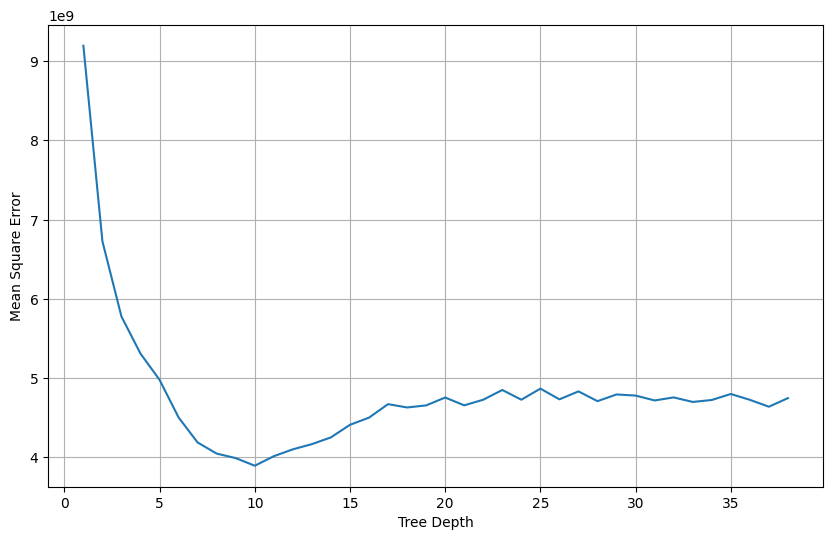

In [88]:
plt.close()
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

mses = []
for depth in range(1, (model.tree_.max_depth + 1)):
    d_tree_reg = DecisionTreeRegressor(max_depth=depth)
    d_tree_reg.fit(X_train, y_train)
    tree_predictions = d_tree_reg.predict(X_test)
    mses.append(mean_squared_error(y_test, tree_predictions))

tree_depths = [depth for depth in range(1, (model.tree_.max_depth + 1))]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(tree_depths, mses)
plt.xlabel("Tree Depth")
plt.ylabel("Mean Square Error")

In [89]:
print(model.get_n_leaves())
print(model.get_depth())

13846
38


### Random Forests

Hyperparameter Tuning

In [ ]:
# import sklearn
# sklearn.metrics.get_scorer_names()

Using GridSearchCV for hyperparamter tuning. Uncomment to run it for the first time.

*Please Note: It can take about 3 mins to run!*

In [90]:
#Define a base Random Forest model
rf = RandomForestRegressor(random_state=r)

# Hyperparameter tuning for Random Forest using GridSearchCV and fit the data.
from sklearn.model_selection import GridSearchCV

params = {
    # 'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [1,5,10,20,50,100],
    'n_estimators': [10,25,30,50,100,200],
    'max_features': [1,2,3,6,10]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 3,
                           n_jobs=-1, verbose=1, scoring="r2")

grid_search.fit(X_train, y_train)

# Output: Fitting 3 folds for each of 180 candidates, totalling 540 fits

Fitting 3 folds for each of 180 candidates, totalling 540 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': [1, 2, 3, 6, 10],
                         'min_samples_leaf': [1, 5, 10, 20, 50, 100],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='r2', verbose=1)

In [91]:
grid_search.best_estimator_

# Output: RandomForestRegressor(max_features=6, n_estimators=200, random_state=42)

RandomForestRegressor(max_features=6, n_estimators=200, random_state=42)

In [92]:
print(grid_search.best_params_)
best_features=grid_search.best_params_['max_features']
best_min_leaf=grid_search.best_params_['min_samples_leaf']
best_estimators=grid_search.best_params_['n_estimators']

# best_features=6
# best_min_leaf=1
# best_estimators=200

## Output: {'max_features': 6, 'min_samples_leaf': 1, 'n_estimators': 200}

{'max_features': 6, 'min_samples_leaf': 1, 'n_estimators': 200}


# Comparing Models

In [94]:
names = [
    "Multiple Linear Regression",
    "Decision Tree",
    "Ensemble",
    "Random Forest",
    "Random Forest with pruning",
]

regressors = [
    LinearRegression(),
    DecisionTreeRegressor(max_depth=10,random_state=r),
    BaggingRegressor(estimator=DecisionTreeRegressor(random_state=r), n_estimators=25, random_state=r),
    RandomForestRegressor(random_state=r),
    RandomForestRegressor(n_estimators=best_estimators, max_features=best_features,
                          min_samples_leaf=best_min_leaf, random_state=r)
]

In [95]:
#Iterating over all the classifiers
data = []
for name, reg in zip(names, regressors):
  #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  reg.fit(X_train, y_train)
  y_prediction = reg.predict(X_test)

  mse = mean_squared_error(y_test, y_prediction)
  mae = mean_absolute_error(y_test, y_prediction)
  r2 = r2_score(y_test, y_prediction)
  exp_var = explained_variance_score(y_test,y_prediction,multioutput='uniform_average')
  data.append([name, mse, mae, r2, exp_var])

In [96]:
print(tabulate(data, headers=["Model", "MSE", "MAE", "R2 score", "Expected Variance Score"], tablefmt='fancy_outline',colalign=("center",)))

╒════════════════════════════╤═════════════╤═════════╤════════════╤═══════════════════════════╕
│           Model            │         MSE │     MAE │   R2 score │   Expected Variance Score │
╞════════════════════════════╪═════════════╪═════════╪════════════╪═══════════════════════════╡
│ Multiple Linear Regression │ 4.73849e+09 │ 50087.5 │   0.638983 │                  0.639008 │
│       Decision Tree        │ 3.87667e+09 │ 41525.1 │   0.704644 │                  0.704649 │
│          Ensemble          │ 2.44421e+09 │ 32268.6 │   0.81378  │                  0.813862 │
│       Random Forest        │ 2.36932e+09 │ 31725.1 │   0.819486 │                  0.819554 │
│ Random Forest with pruning │ 2.3623e+09  │ 31831.5 │   0.820021 │                  0.820045 │
╘════════════════════════════╧═════════════╧═════════╧════════════╧═══════════════════════════╛


## Importance scores: Feature Importance

A property of the Random Forest ensemble method in sklearn is that they let you print importance scores for features in the dataset.

### 1. Importance and visualisation

In [97]:
rf = RandomForestRegressor(random_state=r)
rf.fit(X_train,y_train)

#Finding the important features using the built-in Gini importance

# Get numerical feature importances
feature_names = X.columns
importances = rf.feature_importances_

# Dataframe with features and importances, # Sort the feature importances by most important first
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values('Importance', ascending=False)

feature_imp_df

,Feature,Importance
7,median_income,0.487945
9,ocean_proximity_INLAND,0.142947
0,longitude,0.104064
1,latitude,0.098338
2,housing_median_age,0.052568
5,population,0.034489
3,total_rooms,0.025109
4,total_bedrooms,0.024537
6,households,0.018759
12,ocean_proximity_NEAR OCEAN,0.007007


Text(0, 0.5, 'Features')

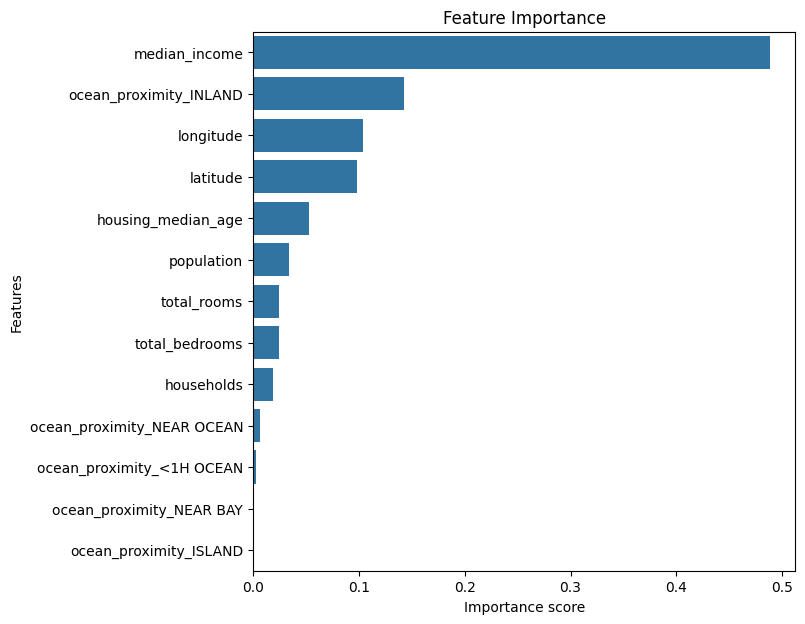

In [98]:
# Creating a seaborn bar plot
plt.figure(figsize=(7,7))
sns.barplot(x=feature_imp_df['Importance'],y=feature_imp_df['Feature'],data=feature_imp_df)
plt.title("Feature Importance")
plt.xlabel("Importance score")
plt.ylabel("Features")

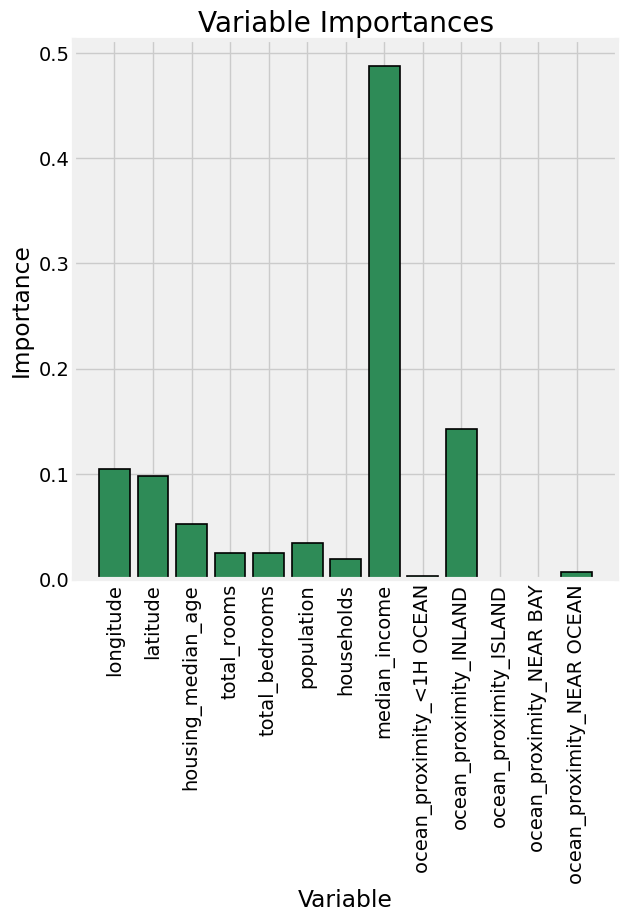

In [99]:
# Reset style
plt.figure(figsize=(7,7))
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'seagreen', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_names, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Accuracy after dropping least important feature according to Gini importance

In [100]:
[col for col in X.columns if 'ocean' in col]

['ocean_proximity_<1H OCEAN',
 'ocean_proximity_INLAND',
 'ocean_proximity_ISLAND',
 'ocean_proximity_NEAR BAY',
 'ocean_proximity_NEAR OCEAN']

In [101]:
# drop the least important feature from X_train and X_test
drop_columns = ['ocean_proximity_<1H OCEAN','ocean_proximity_ISLAND','ocean_proximity_NEAR BAY','ocean_proximity_NEAR OCEAN','households']

X_train_gini = X_train.drop(drop_columns, axis=1)
X_test_gini = X_test.drop(drop_columns, axis=1)

# Create Random Forest Classifier

r = 42

rf_gini = RandomForestRegressor(n_estimators=best_estimators, max_features=best_features,
                          min_samples_leaf=best_min_leaf, random_state=r)
rf_gini.fit(X_train_gini,y_train)

#Predict the response for test dataset for the models
y_test_pred_rf_gini = rf_gini.predict(X_test_gini)

#print(f'Testing Accuracy for Random Forest model: {r2_score(y_test, y_test_pred_rf)}')
print(f'R2 score for Random Forest model with Gini importance: {r2_score(y_test, y_test_pred_rf_gini)}')

R2 score for Random Forest model with Gini importance: 0.821132340602447


Predict housing prices

Text(0.5, 1.0, 'Residuals of Predictions')

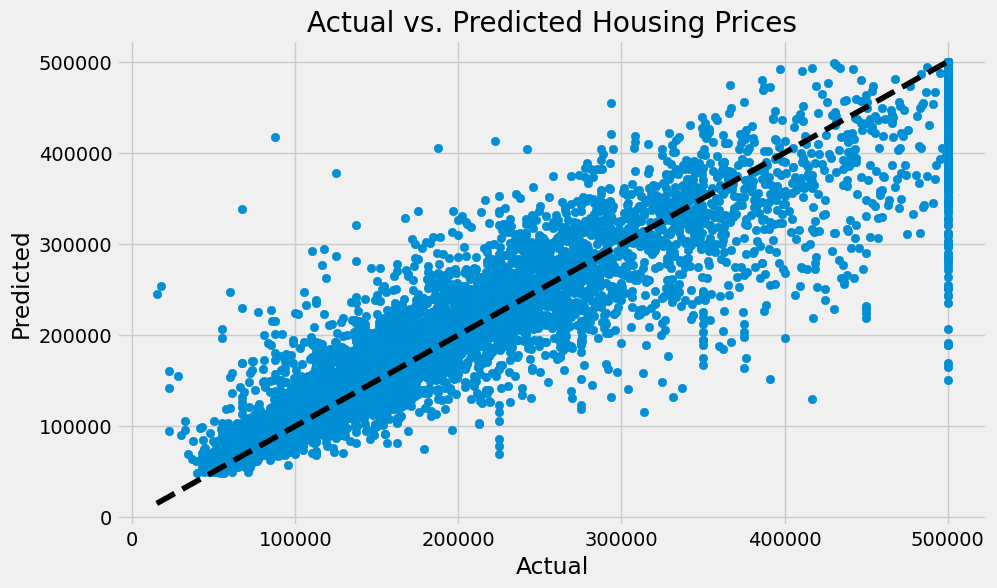

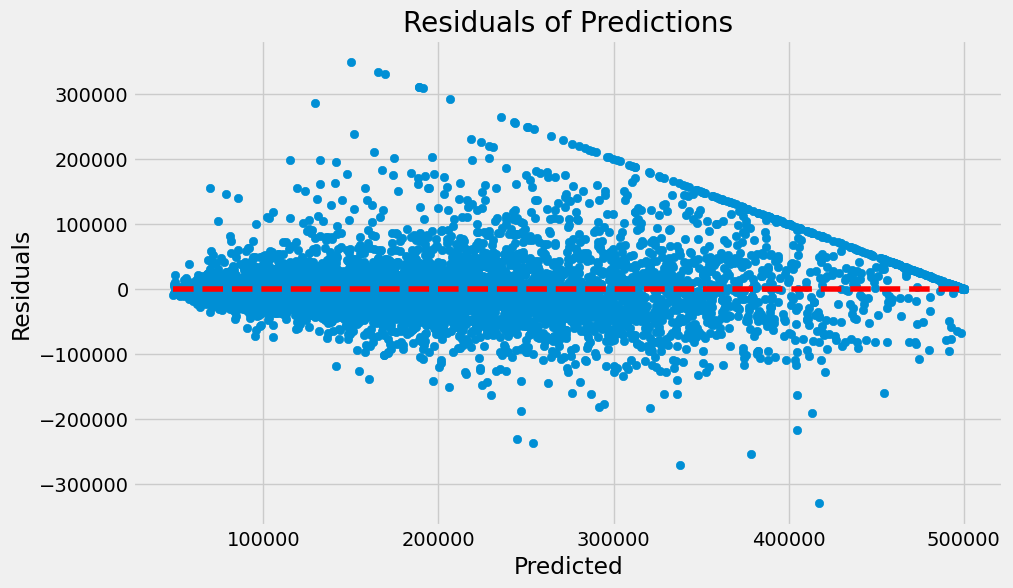

In [102]:
# Predict the housing prices on the test set
y_pred = rf_gini.predict(X_test_gini)

# Plotting the actual vs predicted values
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Housing Prices')

# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(10,6))
plt.scatter(y_pred, residuals)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals of Predictions')

Looks like there are some cutoff values.

The scatter plot of actual vs. predicted home prices shows something interesting. While much of the graph lies somewhat along a line (which usually suggests that linear regression is appropriate), the very end shows a horizontal line at 500,001 USD. Looking at the statistics for the dataset, this is the max home value. For many of these homes, the model predicted much higher prices, and it does seem surprising that the cutoff is precisely at 500,001 USD. Maybe there was some artificial cutoff. Check the mode.

In [103]:
print(housing['median_house_value'].mode())
print(housing['housing_median_age'].mode())

print(housing[housing['median_house_value'] == 500001.0]['median_house_value'].count())
print(housing[housing['housing_median_age'] == 52.0]['housing_median_age'].count())

0    500001.0
Name: median_house_value, dtype: float64
0    52.0
Name: housing_median_age, dtype: float64
965
1273


The above shows that the max value of 500,001 is indeed the most common value in the dataset. It appears 965 times, which is about 4.7% of the entries. This seems suspiciously high, maybe the prices above this threshold value were simply coded as a max value of 500,001. One can try experimenting with removing these values and re-running the regression. (***Note: it did not improve the model performance.***)

In [ ]:
# drop_val = housing[(housing['median_house_value'] == 500001.0) | (housing['housing_median_age'] == 52.0)].index
# housing.drop(drop_val, inplace=True)
# housing.info()